### Chose gene from Assignement 1
Programmatically, get nucleotide sequences for 5 different species that have this gene and:

- Note down the basic info: accession number, title, organism, and length of the sequence
- Determine the GC percentage
- Perform a sequence alignment
- Create a phylogenetic tree with visualisation according to the scores of the sequence alignment
- Using: Entrez, Bio.SeqIO, Bio.Align, Bio.Phyl

### Note down the basic info: accession number, title, organism, and length of the sequence
- using Entrez

In [343]:
from Bio import SeqIO, Entrez
from Bio.Seq import Seq
import pandas as pd
from Bio.Align import MultipleSeqAlignment

# get records according to gene name
def query_id_list(gene_name, species=None):  
    '''
    get an ID list of all entries that have the gene name. 
    The respective species can also be selected. 
    The default value is None, so all species are searched for. 
    '''
    handle = None
    # Depending on whether you are looking for a special species or not 
    if species == None:
        handle = Entrez.esearch(db='nucleotide', term=f'{gene_name}[gene]', retmode='xml')
    else:
        handle = Entrez.esearch(db='nucleotide', term=f'{species}[Orgn] AND {gene_name}[gene]', retmode='xml')
    records = Entrez.read(handle)
    
    # Append all records (in this case IDs) to one String with "," and then make string list
    id_list = ",".join(records["IdList"][:])
    id_list.split(',')
    return id_list

def download_recordsXML(id_list):
    '''
    The first approach was to get the entries in XML format. Therefore this function.
    It is still integrated as there is no time to rewrite the program. 
    In future: use "download_recordsText" instead.
    
    Note: The NCBI changed the default retmode in Feb 2012, so many databases which previously 
          returned text output now give XML.
    link: https://biopython.org/docs/1.76/api/Bio.Entrez.html
    '''
    handle = Entrez.efetch(db="nucleotide", id=id_list, retmode="xml")
    records = Entrez.read(handle, "genbank")
    return records

def download_recordsText(id_list):
    '''
    The second approach was to use retmode="text". 
    This made it easier to access some attributes. Above all, the problem with the multi-sequence 
    alignment was no longer that the "Seq" object was missing parameters. 
    '''
    handle = Entrez.efetch(db="nucleotide", id=id_list, rettype="gb", retmode="text")
    records = SeqIO.parse(handle, "genbank")
    return records

def get_all_orthologs(records):
    '''
    Just for getting alle orthologs from the query. Eliminates duplicate entries, which does not
    matter since only names are important here.
    '''
    orthologs = [] 
    for record in records:
        orthologs.append(record['GBSeq_organism'])
    
    # Eliminates duplicate entries in a roundabout way
    orthologs = list(dict.fromkeys(orthologs))
    return orthologs
    


# 1) define E-Mail and gene name
Entrez.email = "be18b070@technikum-wien.at";
gene_name = "SIRT1"

# 2) define gene and serach 5 orthologs
id_list = query_id_list(gene_name)
records = download_recordsXML(id_list)
orthologs = get_all_orthologs(records)[:5]

# 3) serach for these species and get accession number
othologs_with_nr = {}
for ortholog in orthologs:
    id_list = query_id_list(gene_name, ortholog)
    ID = id_list.split(",")[0]
    #print(f"name: {ortholog} -> accession number: {ID}") 
    othologs_with_nr[ortholog] = ID 

    
# 4) get sequences from accession numbers
acession_numbers = list(othologs_with_nr.values())

# 5) get records from acession number and sequences
records = download_recordsText(acession_numbers)


# 6) make list of records
records_list = []
for record in records:
    records_list.append(record)
    
print("process completed")
print(f"Using orthologs: {orthologs}")

process completed
Using orthologs: ['Mus musculus', 'Rattus norvegicus', 'Homo sapiens', 'Pipistrellus kuhlii', 'Lemur catta']


### As an intermediate step, create pandas dataframe with the content of each species 

In [344]:
# Creating a data list which will be used until the end
data_list = []

# Create records list and add, as required, accession number, title, organism, and length of the sequence
for i, record in enumerate(records_list):
    infos = {
        "accession number" : record.name,
        "title" : record.description,
        "organism" : record.annotations["source"],
        "length of seq" : len(record.seq),
    }
    
    pandas_dataframe = pd.DataFrame(list(infos.items()), columns = ['Parameter', 'Content']);
    data_list.append(pandas_dataframe)

    print(f"\nEntry: {i+1} ---------- \n{pandas_dataframe}")
    


Entry: 1 ---------- 
          Parameter                                            Content
0  accession number                                       NM_001159589
1             title  Mus musculus sirtuin 1 (Sirt1), transcript var...
2          organism                         Mus musculus (house mouse)
3     length of seq                                               3793

Entry: 2 ---------- 
          Parameter                                    Content
0  accession number                               NM_001372090
1             title  Rattus norvegicus sirtuin 1 (Sirt1), mRNA
2          organism             Rattus norvegicus (Norway rat)
3     length of seq                                       3184

Entry: 3 ---------- 
          Parameter                                            Content
0  accession number                                       NM_001142498
1             title  Homo sapiens sirtuin 1 (SIRT1), transcript var...
2          organism                               H

### Determine the GC percentage

In [345]:
# New Approach:
from Bio.SeqUtils import GC

# calculate GC percentage and add it to DataFrame
# Note (!): If "data in data_list" is used it's not possible to assign "data" a new value. It seems to be 
#           not longer connected. This is the reason, why I'm working with the index here.
#           Otherwise, "for data, record in zip(data_list, record_list) was the previous approach
for i in range(len(data_list)):
    # get GC percentage
    percentage_gc = GC(records_list[i].seq)
    # make DataFrame of GC percentage and
    df = pd.DataFrame([{"GC percentage", percentage_gc}], columns=["Parameter", "Content"])
    # add it to existing Dataframe
    data_list[i] = data_list[i].append(df, ignore_index=True)
        

data_list

# OLD Approach for finding the GC percentage:
#for record in records_list:
#    number_gc = record.seq.count("GC")
#    length = len(record.seq)
#    #length = infos["length of seq"] # This was from fetched XML record
#    percentage = int(number_gc) / int(length) * 100;
#    print(f"{percentage} % --> GC percentage of {infos['organism']}")

[          Parameter                                            Content
 0  accession number                                       NM_001159589
 1             title  Mus musculus sirtuin 1 (Sirt1), transcript var...
 2          organism                         Mus musculus (house mouse)
 3     length of seq                                               3793
 4     GC percentage                                           42.55207,
           Parameter                                    Content
 0  accession number                               NM_001372090
 1             title  Rattus norvegicus sirtuin 1 (Sirt1), mRNA
 2          organism             Rattus norvegicus (Norway rat)
 3     length of seq                                       3184
 4     GC percentage                                  36.714824,
           Parameter                                            Content
 0  accession number                                       NM_001142498
 1             title  Homo sapiens sir

### Perform a sequence alignment
- Of these 5 sequences
- Bio.Align

In [346]:
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO
import copy

# 1) Make all the sequences the same length. 
#    I used the the following source:
#    https://stackoverflow.com/questions/32833230/biopython-alignio-valueerror-says-strings-must-be-same-length
def normalized_sequence_length(records):
    max_len = max(len(record.seq) for record in records)
    
    for record in records: 
        if len(record.seq) != max_len:
            sequence = str(record.seq).ljust(max_len, '.')
            record.seq = Seq(sequence)
            
    assert all(len(record.seq) == max_len for record in records)
    
    return records

# 2) make a copy so that the old list is not affected
records_list_copy = copy.deepcopy(records_list)

# 3) perform sequence alignement
align  = MultipleSeqAlignment(normalized_sequence_length(records_list_copy))

# 4) show the alignement
print(align)

Alignment with 5 rows and 3793 columns
GCCAGTGCCGCGCGTCGAGCGGAGCAGAGGAGGCGAGGGCGGAG...TAA NM_001159589.2
GTTTCTGTTTCCTGTGGGATACCTGACTTCAGATCAAGAGATGG...... NM_001372090.1
GCATCTCCTCCTCCCTCTCCCCGGGCTCCTACTGGCCTGAGGTT...... NM_001142498.2
ATAACCTTCTGTTTGGTGATGAAATAATTACCAATGGTTTCCAT...... XM_045581817.1
AAGAAACAGCATTGAAGCATTATTTGGGGGGAAAAACACACACA...... XM_045567941.1


NM_001159589.2	0
NM_001372090.1	0.773002900079093	0
NM_001142498.2	0.7585025046137622	0.7276562088056947	0
XM_045581817.1	0.8547324017927762	0.6704455576061166	0.7830213551278671	0
XM_045567941.1	0.7706301080938571	0.6095438966517268	0.7302926443448458	0.6862641708410229	0
	NM_001159589.2	NM_001372090.1	NM_001142498.2	XM_045581817.1	XM_045567941.1


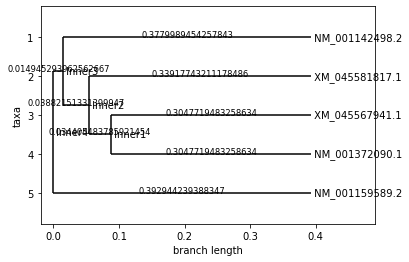

In [347]:
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import Phylo

# 1) Calculate the distances. It would also be possible to use another method than 'identity', 
#    but it was not specified which one should be used.
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(align)
# print the distances
print(dm)

# 2) Construct the phylogenetic tree.
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)

# 3) Plot the phylogenetic tre and also show the distances and accession number on the print. 
#   I assume it looks dofferent in jupyter than in another IDE.
#Phylo.draw_ascii(tree) # plot just in ascii style ;)
#Phylo.draw(tree)       # plot without distances

Phylo.draw(tree, branch_labels=lambda c: c.branch_length) # plot with distances

## Transform the nucleotide sequences into protein ones, and:
- Calculate: instability, aromaticity, isoelectric point
- Analyse the structure via the fractions of amino acids that tend to be in helix, turn or sheet

In [348]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

protein_list = []
fractions_list = []

for i, record in enumerate(records_list):
    # Translate to protein and add to protein list
    protein_as_str = str(record.seq.translate())
    protein_list.append(protein_as_str)
    
    # Calculate the instability, isoelectric_point, aromaticity
    instability = ProteinAnalysis(protein_as_str.replace("*","")).instability_index()
    isoelectric_point = ProteinAnalysis(protein_as_str).isoelectric_point()
    aromaticity = ProteinAnalysis(protein_as_str).aromaticity()
    
    # Caluclating the fraction of helix, turn and sheet.
    # The .secondary_structure_fraction() returns a tuple of three floats (Helix, Turn, Sheet).
    # This list indicates which fraction of amino acid tend to be in Helix, Turn or Sheet
    fractions_list.append(ProteinAnalysis(protein_as_str).secondary_structure_fraction())
    
    # Add instability and aromaticity to DataFrame
    # (!) I had an issue and thus to swap the columns
    df = pd.DataFrame([{"instability", instability}], columns=["Content", "Parameter"])
    data_list[i] = data_list[i].append(df, ignore_index=True)
    df = pd.DataFrame([{"aromaticity", aromaticity}], columns=[ "Content", "Parameter"])
    data_list[i] = data_list[i].append(df, ignore_index=True)
    


P:\Anaconda3\lib\site-packages\Bio\Seq.py:2338: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


## Thus, the code must automatically generate:
- A table with: accession number and title, organism, length of the sequence, GC percentage, instability, aromaticity

- Phylogenetic tree visualisation with accession numbers and distances mentioned on the graph

          Parameter                                            Content
0  accession number                                       NM_001159589
1             title  Mus musculus sirtuin 1 (Sirt1), transcript var...
2          organism                         Mus musculus (house mouse)
3     length of seq                                               3793
4     GC percentage                                           42.55207
5     GC percentage                                           42.55207
          Parameter                                    Content
0  accession number                               NM_001372090
1             title  Rattus norvegicus sirtuin 1 (Sirt1), mRNA
2          organism             Rattus norvegicus (Norway rat)
3     length of seq                                       3184
4     GC percentage                                  36.714824
5     GC percentage                                  36.714824
          Parameter                                           

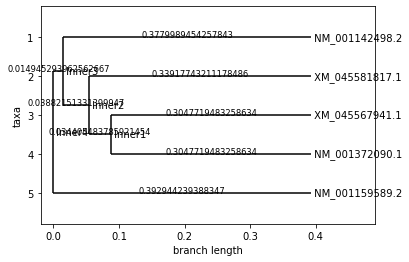

In [342]:
# 1) show table with
#  -> accession number
#  -> title
#  -> organism
#  -> length of sequence
#  -> GC percentage
#  -> instability
#  -> aromaticy
for data in data_list:
    print(data)

# 2) phylogenetic tree visualisation
#  -> with accession numbers
#  -> and distances mentioned on the graph
Phylo.draw(tree, branch_labels=lambda c: c.branch_length)
